### Linkrot for OGC and OpenSearch services

This includes everything, not just description documents.

9,379 URLs checked.

For everything, binned by status code (900 is some request exception).

Reminder, some OGC servers don't respond correctly to HEAD requests. Correctly is a little off - they don't support the request for a service call at all (so no GetCapabilities). That is a lighter weight request - we don't need to pull everything for a heartbeat check as a harvester/secondary portal. I don't think and havent found anything in the OGC documents about including support for that, but it is something to consider under increased automated traffic (be polite!)


| Status | Count | 
|--------|-------| 
| 200    | 7827  | 
| 300    | 190   | 
| 400    | 680   | 
| 500    | 296   | 
| 900    | 386   | 



## NOTE: THIS IS INCORRECT DATA. IGNORE BELOW IF YOU SEE THIS MESSAGE. 

By Protocol

| Status | OGC  | OGC (%) | OpenSearch | OpenSearch (%) | 
|--------|-----:|--------:|-----------:|---------------:| 
| 200    | 2530 | 58.8    | 4338       | 78.7           | 
| 300    | 26   | 0.6     | 190        | 3.4            | 
| 400    | 1578 | 36.7    | 487        | 8.8            | 
| 500    | 29   | 0.7     | 270        | 4.9            | 
| 900    | 139  | 3.2     | 225        | 4.1            | 


OGC Status Codes by Harvest Date (%)

| Harvest Date | 200  | 300 | 400  | 500 | 900 | 
|--------------|------|-----|------|-----|-----| 
| 7/1/2014     | 54.9 | 3.3 | 35.3 | 0.0 | 6.5 | 
| 10/1/2014    | 82.9 | 0.2 | 16.8 | 0.2 | 0.0 | 
| 3/1/2015     | 43.5 | 0.6 | 49.8 | 0.0 | 6.1 | 
| 6/1/2015     | 69.2 | 0.4 | 27.4 | 1.6 | 1.4 | 
| 7/1/2015     | 64.3 | 1.0 | 32.2 | 0.6 | 1.8 | 
| 8/1/2015     | 47.2 | 0.3 | 46.3 | 0.2 | 5.8 | 
| 9/1/2015     | 43.5 | 0.4 | 51.7 | 1.8 | 2.6 | 


OpenSearch Status Codes by Harvest Date (%)

| Harvest Date | 200  | 300 | 400  | 500  | 900 | 
|--------------|------|-----|------|------|-----| 
| 7/1/2014     | 95.6 | 1.5 | 1.5  | 0.2  | 1.2 | 
| 10/1/2014    | 49.5 | 7.9 | 35.0 | 2.4  | 5.2 | 
| 3/1/2015     | 65.5 | 7.7 | 13.9 | 7.5  | 5.4 | 
| 6/1/2015     | 83.4 | 2.2 | 1.1  | 10.4 | 2.9 | 
| 7/1/2015     | 83.7 | 1.6 | 1.1  | 9.9  | 3.7 | 
| 8/1/2015     | 93.4 | 1.6 | 0.8  | 0.7  | 3.5 | 
| 9/1/2015     | 88.9 | 2.2 | 0.3  | 1.4  | 7.2 | 



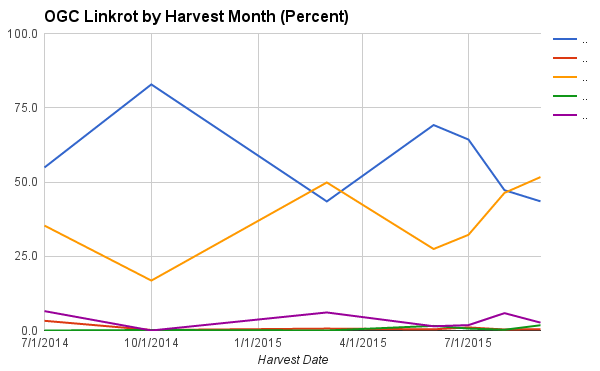

In [1]:
from IPython.display import Image
Image(filename='screenshots/ogc_linkrot.png') 

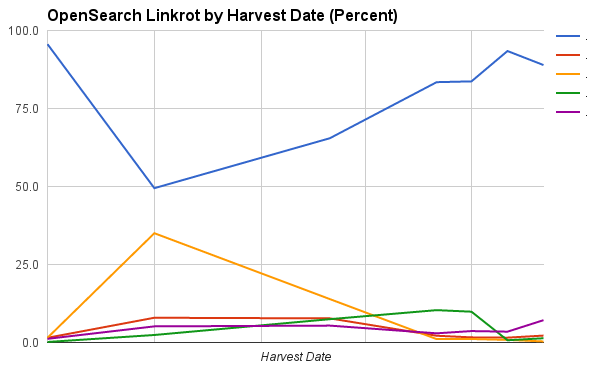

In [2]:
from IPython.display import Image
Image(filename='screenshots/opensearch_linkrot.png') 

A bit of speculation on the difference - opensearch (in our set) is running a necessary website function (it drives search), ogc doesn't have that same role. And OpenSearch the spec with the resultset options haven't really changed much so it wouldn't be so affected by versions (is it ogc linkrot because our links hit v 1.1.0 and the system now only supports 1.1.1; this is unlikely but possible).

Update: some but not all OGC servers don't respond correctly to HEAD requests. The OGC stats are not accurate, give me a few to verify that any 200 < status < 900 are OK for a GET instead. (ahem, a. r. c. s. e. r. v. e. r.)

An example.

This:

http://basemap.nationalmap.gov/arcgis/services/USGSHydroNHD/MapServer/WMSServer?request=GetCapabilities&service=WMS

returns a 400 Bad Request from a HEAD request but a valid (200 OK) WMS GetCapabilities response (valid as in it returned a getcap response, not that the xml is valid).

In [1]:
%matplotlib inline
import pandas as pd
import json as js  # name conflict with sqla
import sqlalchemy as sqla
from sqlalchemy.orm import sessionmaker


In [5]:
# grab the clean text from the rds
with open('../local/big_rds.conf', 'r') as f:
    conf = js.loads(f.read())

# our connection
engine = sqla.create_engine(conf.get('connection'))

In [18]:
sql = """
with i
as (
    select d.response_id, jsonb_array_elements(d.identity::jsonb) ident
    from identities d
    where d.identity is not null
)

select i.ident->'protocol' as protocol,
  date_trunc('month', r.initial_harvest_date)::date as harvest_month, 
  r.source_url,
  round(s.status, -2) as status_code
from responses r join i on r.id = i.response_id
  join service_linkrot s on s.response_id = r.id
where i.ident->>'protocol' = 'OGC' or i.ident->>'protocol' = 'OpenSearch'
order by protocol, date_trunc('month', r.initial_harvest_date)::date ASC
limit 25;
"""

In [17]:
df = pd.read_sql(sql, engine)

for d in df.itertuples():
    print int(d[4]), d[3], d[2]

900 http://hsip.geoplatform.gov/arcgis/services/HSIP_Public/TransportationWater/MapServer/WMSServer?request=GetCapabilities&service=WMS 2014-07-01
200 http://services.azgs.az.gov/ArcGIS/services/aasggeothermal/CAWellLogs/MapServer/WFSServer?request=GetCapabilities&service=WFS 2014-07-01
400 http://basemap.nationalmap.gov/arcgis/services/USGSHydroNHD/MapServer/WMSServer?request=GetCapabilities&service=WMS 2014-07-01
400 http://encdirect.noaa.gov/arcgis/services/cmsp/restricted_areas/MapServer/WMSServer?request=GetCapabilities&service=WMS 2014-07-01
400 http://hdds.usgs.gov/arcgis/services/201001_Earthquake_Haiti/ImageServer/WMSServer?request=GetCapabilities&service=WMS 2014-07-01
200 http://egisws02.nos.noaa.gov/ArcGIS/services/ESI/ESI_VirginIslands_TandE_Data/MapServer/WMSServer?request=GetCapabilities&service=WMS 2014-07-01
400 http://certmapper.cr.usgs.gov/arcgis/services/geology/africa/MapServer/WMSServer?request=GetCapabilities&service=WMS 2014-07-01
200 http://egisws02.nos.noaa.go